# Unit 7 Data Storytelling

Google doc:
https://docs.google.com/document/d/1Cf6_IJV56P5mY2WkrdJD7iDIO1NBuj4yDzEpx_td9fk/edit?usp=sharing

Presentation: 
https://docs.google.com/presentation/d/1dge2W830n8LZkilj7NK2rZiQ0nmB0Y8ULvQU3NYq3AY/edit?usp=sharing


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

%matplotlib inline

In [2]:
master_df = pd.read_csv(r'master_df.csv',encoding='latin-1')
master_df.head()
# master_df.Rate.plot.kde()

,Unnamed: 0,Date,RegionName,Population,Afford_idx,Property_Crimes,Violent_Crimes,SalePrice,UnemployRate,Rate,Days_On_Zillow,Monthly_List_Zillow
0,0,2013-01-01,Alameda County,1554138,0.32,1018333,151634,429100.0,8.3,3.41,79.0,2326.0
1,1,2013-02-01,Alameda County,1554138,0.32,1018333,151634,428400.0,7.8,3.53,70.0,2229.0
2,2,2013-03-01,Alameda County,1554138,0.32,1018333,151634,436100.0,7.5,3.57,51.0,2115.0
3,3,2013-04-01,Alameda County,1554138,0.25,1018333,151634,441500.0,7.0,3.45,46.5,2105.0
4,4,2013-05-01,Alameda County,1554138,0.25,1018333,151634,460100.0,7.0,3.54,45.0,2159.0


### 1. Compare sales price trend between 3 counties represending SF bay area, northern CA and Southern CA.

#### 1.1 Compare sales price trend

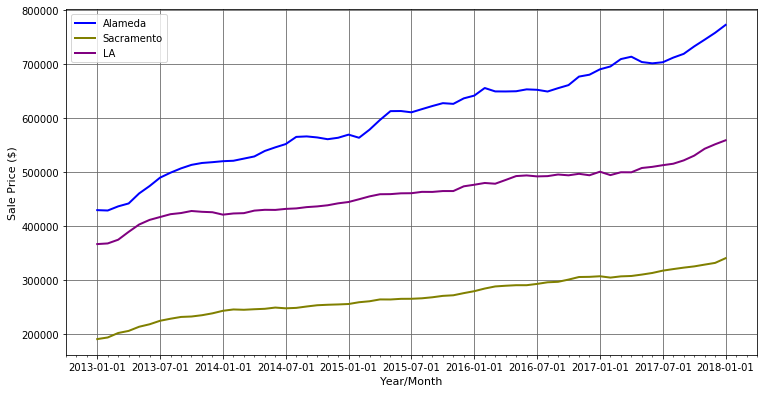

In [3]:
alameda_df= master_df[master_df.RegionName == 'Alameda County']
alameda_df.reset_index(inplace=True)
sacramento_df= master_df[master_df.RegionName == 'Sacramento County']
sacramento_df.reset_index(inplace=True)
la_df= master_df[master_df.RegionName == 'Los Angeles County']
la_df.reset_index(inplace=True)

fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])

axes.plot( 'Date', 'SalePrice', data=alameda_df, marker='', color='blue', linewidth=2)
axes.plot( 'Date', 'SalePrice', data=sacramento_df, marker='', color='olive', linewidth=2)
axes.plot( 'Date', 'SalePrice', data=la_df, marker='', color='purple', linewidth=2,)
axes.legend(['Alameda', 'Sacramento', 'LA'])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Sale Price ($)', fontsize=11)
 
# Note for myself: tick spacing: https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/3/ch03lvl1sec48/controlling-tick-spacing    
axes.xaxis.set_major_locator(ticker.MultipleLocator(6))
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()


#### 1.2. Compare sale price change % trend

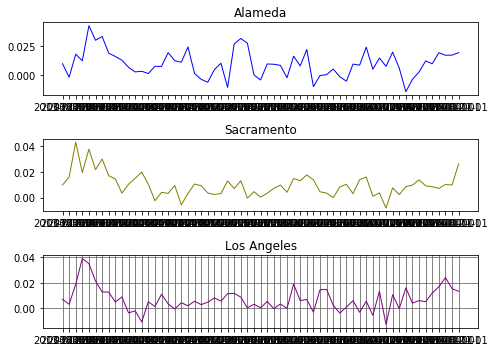

In [4]:
# Calculate the percentage change.

alm_saleprice_change_perc=alameda_df.SalePrice.pct_change()
alm_saleprice_change_perc[0] = alm_saleprice_change_perc.mean()    

sac_saleprice_change_perc=sacramento_df.SalePrice.pct_change()
sac_saleprice_change_perc[0] = sac_saleprice_change_perc.mean() 

la_saleprice_change_perc=la_df.SalePrice.pct_change()
la_saleprice_change_perc[0] = la_saleprice_change_perc.mean()


# plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,5))  

ax1.plot( alameda_df.Date, alm_saleprice_change_perc, marker='', color='blue', linewidth=1)
ax1.title.set_text('Alameda')


ax2.plot( sacramento_df.Date, sac_saleprice_change_perc, marker='', color='olive', linewidth=1)
ax2.title.set_text('Sacramento')

ax3.plot( la_df.Date, la_saleprice_change_perc, marker='', color='purple', linewidth=1,)
ax3.title.set_text('Los Angeles')


plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()

# 9/15/19: Note: Fair price/Appraised value market for property. 


#### 1.3.  9/15/19: plot surrounding county values - Geo/county data. To be used for K-nearest neighbor analysis.

Interesting to see that Santa Clara was growing in almost parallel as Alameda until early 2017 when the growth rate accelerated. 
Marin county, in contrast to other counties seem to display seasonal ups and downs in the sales price. 

In [5]:
# get San Mateo, Contra Coasta, Santa Clara county, Marin county data and do KNN analysis

CA_sales_prices = pd.read_excel(r'C:\Users\yulmee\Documents\Yul-Mee\Springboard\Capstone 1\dataset\cleaned\Zillow_Sale_Prices_County_2008_2015_cleaned.xlsx',encoding='latin-1')


# Convert year-month to date instead: 2008-10 to 2008-10-01 and then to datetime type. 
# For my notes - see http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/ 
# section: Use .apply with axis=1 to send every single row to a function
def set_first_of_month(row):
    datestring = row['year-month'] +'-01'
    return datetime.strptime(datestring, '%Y-%m-%d')

# select county data

def get_cleaned_county_sales_price(CA_sales_prices, county_name):

    county_sales_price = CA_sales_prices.loc[CA_sales_prices['RegionName'] == county_name]
    
    # Melt table to get year and month prices as rows. 
    alm_melt = county_sales_price.melt(id_vars=['RegionID', 'RegionName'], var_name='year-month', value_name='SalePrice')
    
    alm_melt['Date']=alm_melt.apply(set_first_of_month, axis=1)
    alm_melt.drop(['year-month', 'RegionID'],axis=1,inplace=True) 

    sales_price_final = alm_melt
    
    return sales_price_final

C:\Users\yulmee\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\yulmee\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


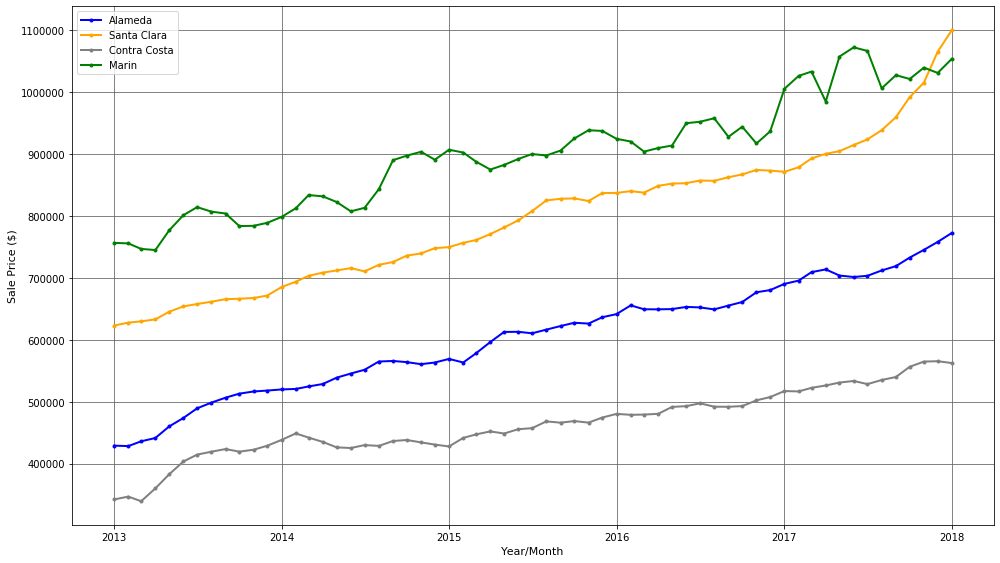

In [6]:
# Get cleaned sales price data for Santa Clara county
sclara_county_name = 'Santa Clara County'
sclara_sales_price_final = get_cleaned_county_sales_price(CA_sales_prices, sclara_county_name)
sclara_sales_price = sclara_sales_price_final[(sclara_sales_price_final['Date'] > '2012-12-31') & (sclara_sales_price_final['Date'] < '2018-01-31')]
sclara_sales_price.drop(['RegionName'],axis=1,inplace=True) 
sclara_sales_price.reset_index(inplace=True)

# Get cleaned sales price data for Contra Costa county
contra_county_name = 'Contra Costa County' 
contra_sales_price_final = get_cleaned_county_sales_price(CA_sales_prices, contra_county_name)
contra_sales_price = contra_sales_price_final[(contra_sales_price_final['Date'] > '2012-12-31') & (contra_sales_price_final['Date'] < '2018-01-31')]
contra_sales_price.drop(['RegionName'],axis=1,inplace=True) 
contra_sales_price.reset_index(inplace=True)

# Get cleaned sales price data for Marin county
marin_county_name = 'Marin County'
marin_sales_price_final = get_cleaned_county_sales_price(CA_sales_prices, marin_county_name)
marin_sales_price = marin_sales_price_final[(marin_sales_price_final['Date'] > '2012-12-31') & (marin_sales_price_final['Date'] < '2018-01-31')]
marin_sales_price.drop(['RegionName'],axis=1,inplace=True) 
marin_sales_price.reset_index(inplace=True)
 
alameda_temp_df = alameda_df.copy()    
alameda_temp_df['Date']= pd.to_datetime(alameda_temp_df['Date']) 

fig1 = plt.figure(figsize=(16,9))
axes2= fig1.add_axes([0.1,0.1,0.8,0.8])

axes2.plot( alameda_temp_df.Date, alameda_temp_df.SalePrice, marker='.', color='blue', linewidth=2)
axes2.plot( sclara_sales_price.Date, sclara_sales_price.SalePrice, marker='.', color='orange', linewidth=2)
axes2.plot( contra_sales_price.Date, contra_sales_price.SalePrice,  marker='.', color='grey', linewidth=2)
axes2.plot( marin_sales_price.Date, marin_sales_price.SalePrice,  marker='.', color='green', linewidth=2)
axes2.legend(['Alameda', 'Santa Clara', 'Contra Costa', 'Marin'])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Sale Price ($)', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

### 2. Compare sales price with Rate - national

Based on graphs, there doesn't seem to be a high correlation between national mortgage rate vs the housing prices in 3 CA counties.  


#### 2.1. Rate trend

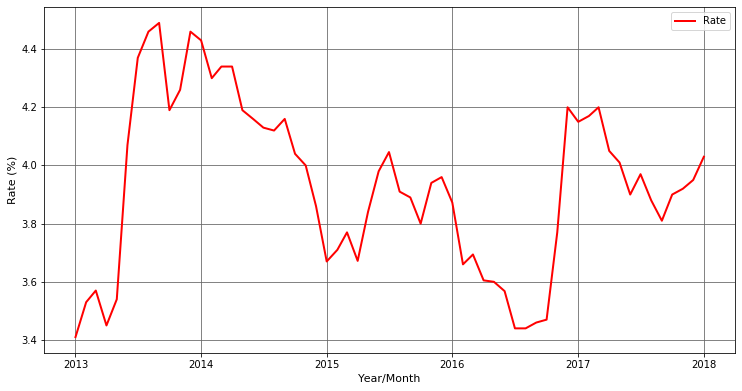

3.9307786885245894
Median Morgate rate between 2013/01/01 - 2018/01/01:3.9307786885245894


In [57]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8]) 
axes.plot( 'Date', 'Rate', data=alameda_df, marker='', color='red', linewidth=2,)

axes.legend(['Rate'])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Rate (%)', fontsize=11)
 
# Note for myself: tick spacing: https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/3/ch03lvl1sec48/controlling-tick-spacing    
#axes.xaxis.set_major_locator(ticker.MultipleLocator(6))
#axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

print('Median Morgate rate between 2013/01/01 - 2018/01/01:' + str(alameda_df.Rate.mean()) )

#### 2.2 Correlation between sales price and national mortgage rate

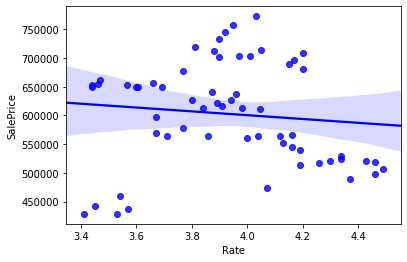

In [8]:
# Alameda
sns.regplot(y=alameda_df.SalePrice, x=alameda_df.Rate,  fit_reg = True, color='blue')

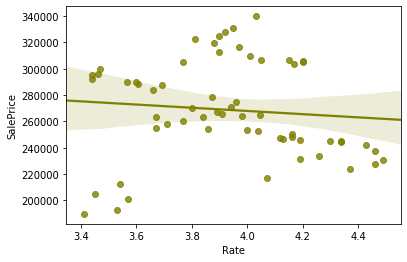

In [9]:
# Sacramento
sns.regplot(y=sacramento_df.SalePrice, x=sacramento_df.Rate,  fit_reg = True, color='olive')

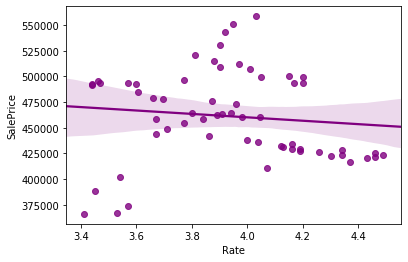

In [58]:
# LA
sns.regplot(y=la_df.SalePrice, x=la_df.Rate,  fit_reg = True, color='purple')

#### 2.3. Rate and Sale price change percentage without lag

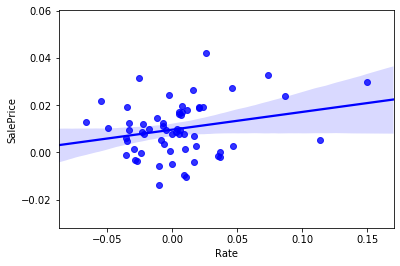

In [11]:
alm_rate_change_perc=alameda_df.Rate.pct_change()
alm_rate_change_perc[0] = alm_rate_change_perc.mean()    

sns.regplot(y=alm_saleprice_change_perc, x=alm_rate_change_perc,  fit_reg = True, color='blue')


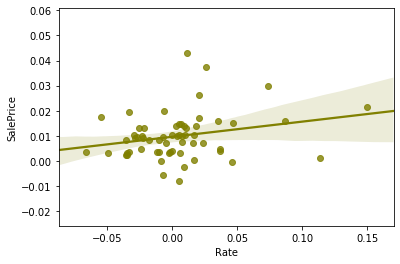

In [12]:
sns.regplot(y=sac_saleprice_change_perc, x=alm_rate_change_perc,  fit_reg = True, color='olive')

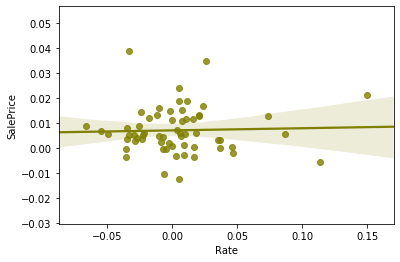

In [13]:
sns.regplot(y=la_saleprice_change_perc, x=alm_rate_change_perc,  fit_reg = True, color='olive')

##### 2.4.1 Alameda - Compare national mortgage rate and Sale price change percentage

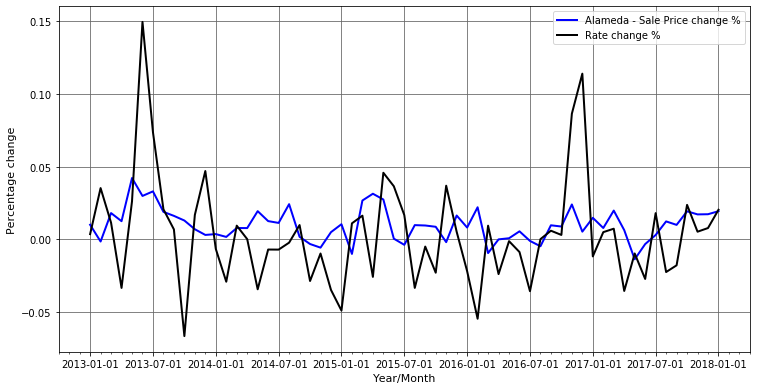

In [14]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8]) 
axes.plot( alameda_df.Date, alm_saleprice_change_perc,  marker='', color='blue', linewidth=2)
axes.plot( alameda_df.Date, alm_rate_change_perc, marker='', color='black', linewidth=2) 
axes.legend(['Alameda - Sale Price change %', 'Rate change %', ])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Percentage change', fontsize=11)
 
# Note for myself: tick spacing: https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/3/ch03lvl1sec48/controlling-tick-spacing    
axes.xaxis.set_major_locator(ticker.MultipleLocator(6))
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

#### 2.4. Alameda - Lag rate by month. 

Usually people lock in rates for 30 days or so before purchasing home so the rate change might not take affect for about a month. 

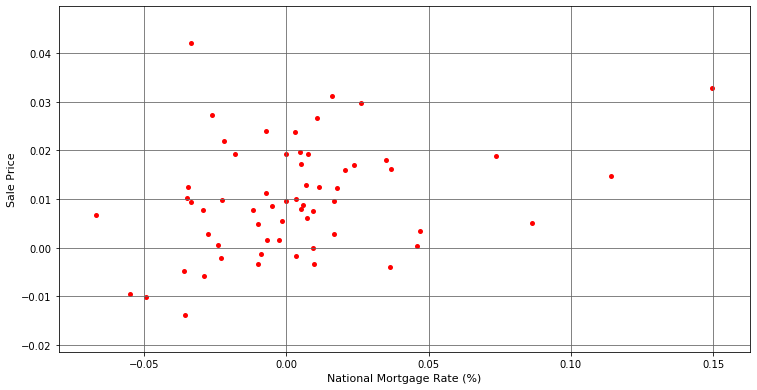

In [15]:
#a = pd.Series([alm_rate_change_perc.mean(), alm_rate_change_perc.mean(), alm_rate_change_perc.mean()])
a = pd.Series([alm_rate_change_perc.mean()])
alm_rate_change_perc_delayed = pd.concat([a, alm_rate_change_perc])

alm_rate_change_perc_delayed.drop(alm_rate_change_perc_delayed.tail(1).index,inplace=True) # drop last n rows
 
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8])  

axes.scatter( alm_rate_change_perc_delayed, alm_saleprice_change_perc,  marker='.', color='red', linewidth=2,)

plt.ylabel('Sale Price', fontsize=11)
plt.xlabel('National Mortgage Rate (%)', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

#### 2.5. Alameda, Sacramento and LA County - Lag by Month

In [16]:
# Sacramento
sac_rate_change_perc=sacramento_df.Rate.pct_change()
sac_rate_change_perc[0] = sac_rate_change_perc.mean()    

b = pd.Series([sac_rate_change_perc.mean()])
#b = pd.Series([sac_rate_change_perc.mean(), sac_rate_change_perc.mean(), sac_rate_change_perc.mean()])
sac_rate_change_perc_delayed = pd.concat([b, sac_rate_change_perc])
# drop last 1 rows
sac_rate_change_perc_delayed.drop(sac_rate_change_perc_delayed.tail(1).index,inplace=True) 

# LA

la_rate_change_perc=la_df.Rate.pct_change()
la_rate_change_perc[0] = la_rate_change_perc.mean()    

c = pd.Series([la_rate_change_perc.mean()])
#c = pd.Series([la_rate_change_perc.mean(), la_rate_change_perc.mean(), la_rate_change_perc.mean()])
la_rate_change_perc_delayed = pd.concat([c, la_rate_change_perc])
# drop last 1 rows
la_rate_change_perc_delayed.drop(la_rate_change_perc_delayed.tail(1).index,inplace=True) 


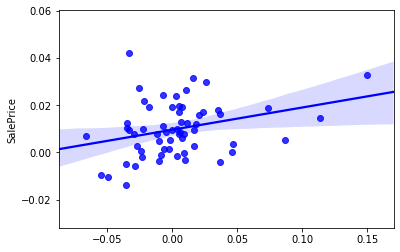

In [17]:
# Alameda
sns.regplot(y=alm_saleprice_change_perc, x=alm_rate_change_perc_delayed,  fit_reg = True, color='blue')

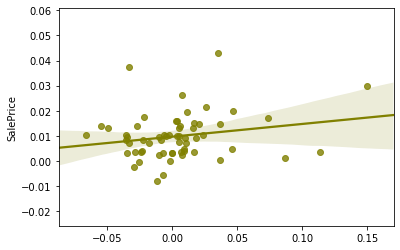

In [18]:
# Sacramento
sns.regplot(y=sac_saleprice_change_perc, x=sac_rate_change_perc_delayed,  fit_reg = True, color='olive')

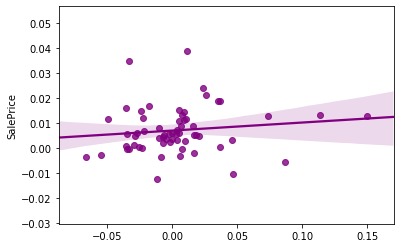

In [19]:
# LA
sns.regplot(y=la_saleprice_change_perc, x=la_rate_change_perc_delayed,  fit_reg = True, color='purple')

##### 2.5.1. Alameda - compare Lag rate by month in same graph

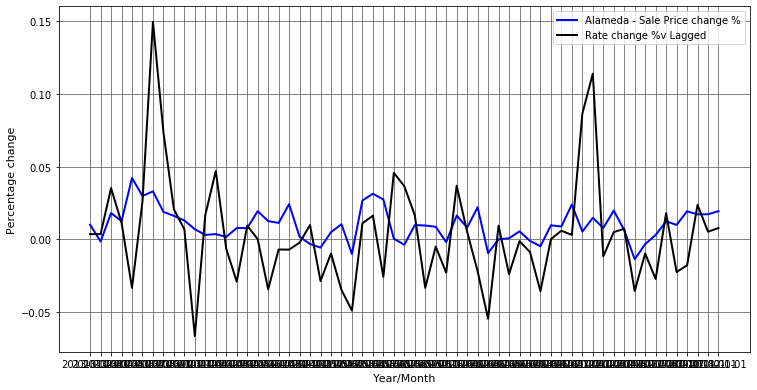

In [20]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8]) 
axes.plot( alameda_df.Date, alm_saleprice_change_perc,  marker='', color='blue', linewidth=2)
#axes.plot( alameda_df.Date, sac_saleprice_change_perc,  marker='', color='olive', linewidth=2)
#axes.plot( alameda_df.Date, la_saleprice_change_perc,  marker='', color='purple', linewidth=2)

axes.plot( alameda_df.Date, alm_rate_change_perc_delayed, marker='', color='black', linewidth=2) 
axes.legend(['Alameda - Sale Price change %', 'Rate change %v Lagged', ])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Percentage change', fontsize=11)
 
# Note for myself: tick spacing: https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/3/ch03lvl1sec48/controlling-tick-spacing    
#axes.xaxis.set_major_locator(ticker.MultipleLocator(6))
#axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

2.5.2. Sacramento County - compare Lag rate by month in same graph

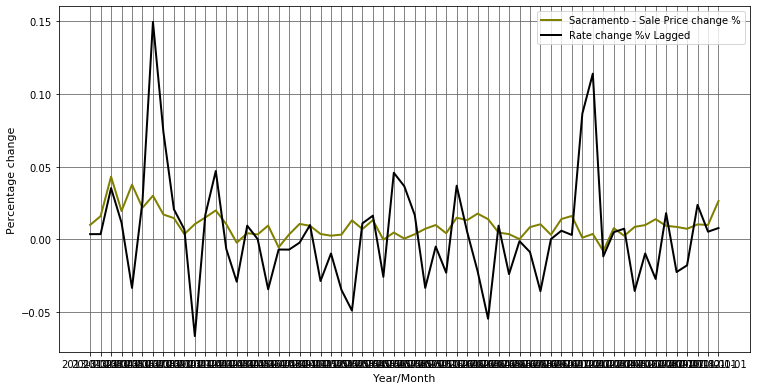

In [21]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8]) 
#axes.plot( alameda_df.Date, alm_saleprice_change_perc,  marker='', color='blue', linewidth=2)
axes.plot( alameda_df.Date, sac_saleprice_change_perc,  marker='', color='olive', linewidth=2)
#axes.plot( alameda_df.Date, la_saleprice_change_perc,  marker='', color='purple', linewidth=2)

axes.plot( alameda_df.Date, alm_rate_change_perc_delayed, marker='', color='black', linewidth=2) 
axes.legend(['Sacramento - Sale Price change %', 'Rate change %v Lagged', ])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Percentage change', fontsize=11)
 
# Note for myself: tick spacing: https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/3/ch03lvl1sec48/controlling-tick-spacing    
#axes.xaxis.set_major_locator(ticker.MultipleLocator(6))
#axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

2.5.3. LA County - compare Lag rate by month in same graph

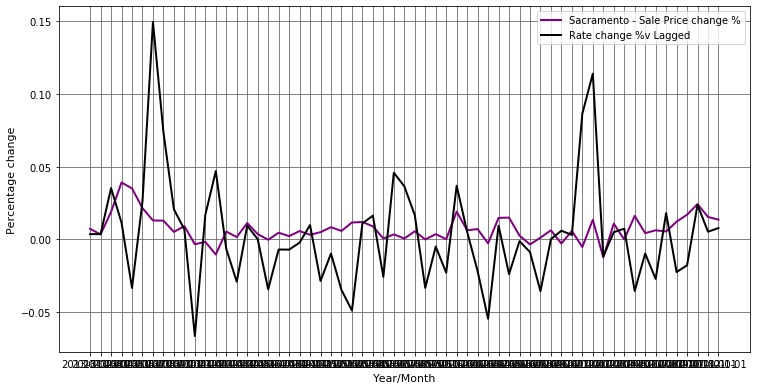

In [22]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8]) 
#axes.plot( alameda_df.Date, alm_saleprice_change_perc,  marker='', color='blue', linewidth=2)
#axes.plot( alameda_df.Date, sac_saleprice_change_perc,  marker='', color='olive', linewidth=2)
axes.plot( alameda_df.Date, la_saleprice_change_perc,  marker='', color='purple', linewidth=2)

axes.plot( alameda_df.Date, alm_rate_change_perc_delayed, marker='', color='black', linewidth=2) 
axes.legend(['Sacramento - Sale Price change %', 'Rate change %v Lagged', ])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Percentage change', fontsize=11)
 
# Note for myself: tick spacing: https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/3/ch03lvl1sec48/controlling-tick-spacing    
#axes.xaxis.set_major_locator(ticker.MultipleLocator(6))
#axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

### 3. Compare sales price with Unemployment Rate - at county level

#### 3.1. Trend timeline

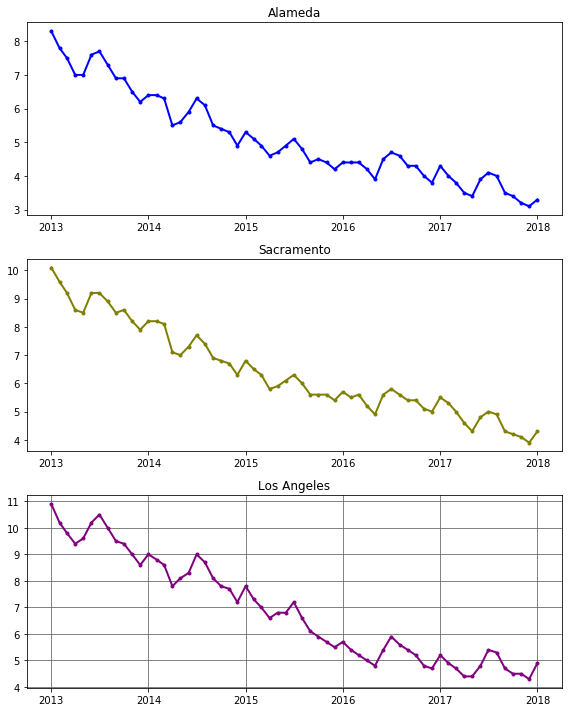

In [79]:
# plot all - alameda, sac, la
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))  

ax1.plot( 'Date', 'UnemployRate', data=alameda_df,  marker='.', color='blue', linewidth=2,)
ax1.title.set_text('Alameda')


ax2.plot( 'Date', 'UnemployRate', data=sacramento_df,   marker='.', color='olive', linewidth=2,)
ax2.title.set_text('Sacramento')

ax3.plot( 'Date', 'UnemployRate', data=la_df,  marker='.', color='purple', linewidth=2,)
ax3.title.set_text('Los Angeles')
 
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()

#### 3.2. Correlation between Unemployment Rate and Sales Price

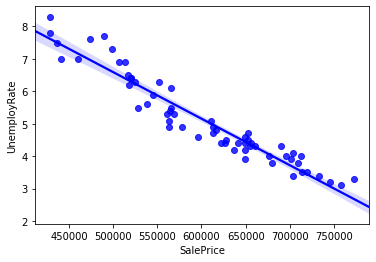

In [24]:
# Alameda
 
sns.regplot(y='UnemployRate', x='SalePrice', data=alameda_df, fit_reg = True, color='blue')

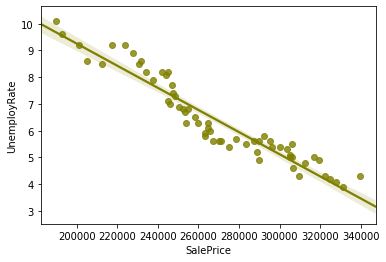

In [25]:
# Sacramento

sns.regplot(y='UnemployRate', x='SalePrice', data=sacramento_df, fit_reg = True, color='olive')

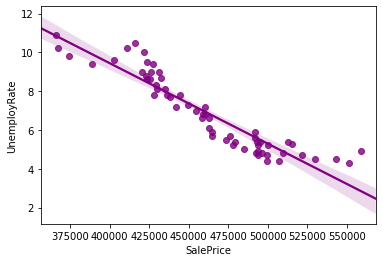

In [26]:
# LA
sns.regplot(y='UnemployRate', x='SalePrice', data=la_df, fit_reg = True, color='purple')

#### 3.3. Smooth out the seasonal changes for the unemployment rate

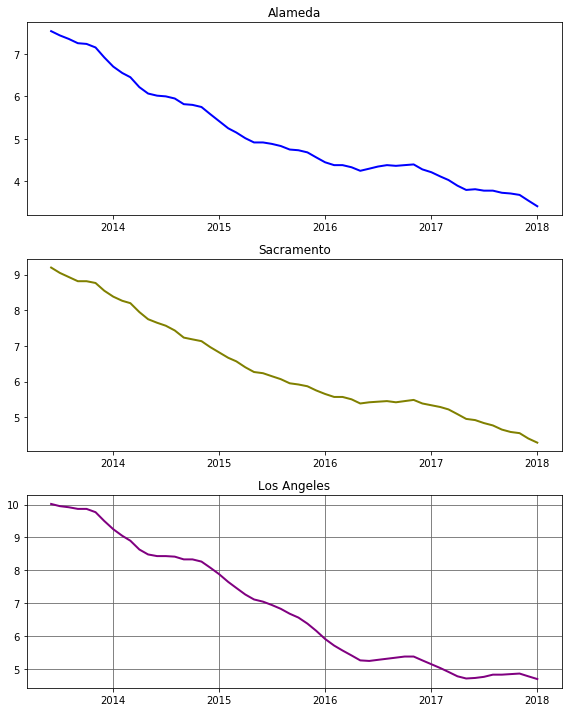

In [85]:
# smooth out the cycles. 
listing_smoothing_factor =6
alm_rolling_unemploy_df = alameda_df.UnemployRate.rolling(listing_smoothing_factor).mean()  
sac_rolling_unemploy_df = sacramento_df.UnemployRate.rolling(listing_smoothing_factor).mean()  
la_rolling_unemploy_df = la_df.UnemployRate.rolling(listing_smoothing_factor).mean()  


# plot all - alameda, sac, la
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))  

ax1.plot( alameda_df.Date, alm_rolling_unemploy_df, marker='', color='blue', linewidth=2,)
ax1.title.set_text('Alameda')


ax2.plot( sacramento_df.Date, sac_rolling_unemploy_df, marker='', color='olive', linewidth=2,)
ax2.title.set_text('Sacramento')

ax3.plot( la_df.Date, la_rolling_unemploy_df, marker='', color='purple', linewidth=2,)
ax3.title.set_text('Los Angeles')


plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()

##### 3.3.1 Correlation between sales price and smoothed unemployment rate

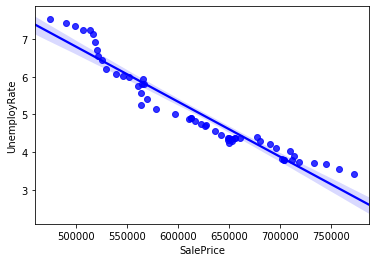

In [87]:
# Alameda 
sns.regplot(y=alm_rolling_unemploy_df, x=alameda_df.SalePrice, fit_reg = True, color='blue')

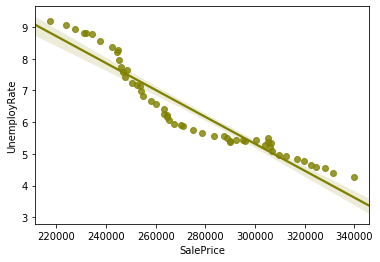

In [89]:
# Sacramento 
sns.regplot(y=sac_rolling_unemploy_df, x=sacramento_df.SalePrice, fit_reg = True, color='olive')

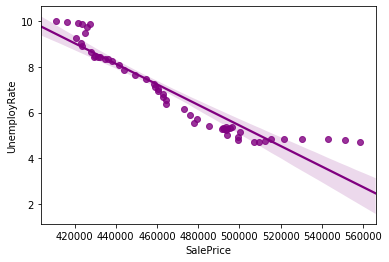

In [91]:
# L.A. 
sns.regplot(y=la_rolling_unemploy_df, x=la_df.SalePrice, fit_reg = True, color='purple')

### 4. Number of days property is listed on Zillow

#### 4.1. Trend

There's yearly cycle but overall, there is slight downward trend. Sacramento's downward trend is steeper than LA or Alameda county, possibly because it's housing prices were more reasonable.  

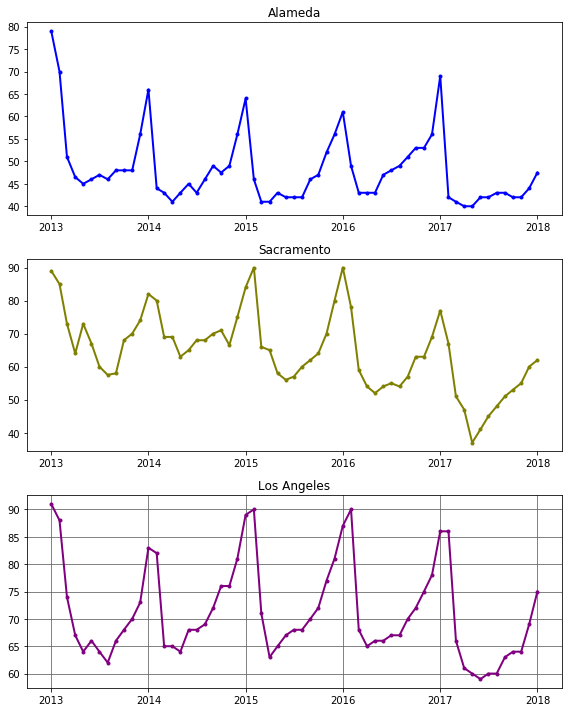

In [81]:
# plot all - alameda, sac, la
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))  

ax1.plot( 'Date', 'Days_On_Zillow',  data=alameda_df,  marker='.', color='blue', linewidth=2,)
ax1.title.set_text('Alameda')


ax2.plot( 'Date', 'Days_On_Zillow', data=sacramento_df,   marker='.', color='olive', linewidth=2,)
ax2.title.set_text('Sacramento')

ax3.plot( 'Date', 'Days_On_Zillow', data=la_df,  marker='.', color='purple', linewidth=2,)
ax3.title.set_text('Los Angeles')

 
plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()

#### 4.2. Smooth out the cycles

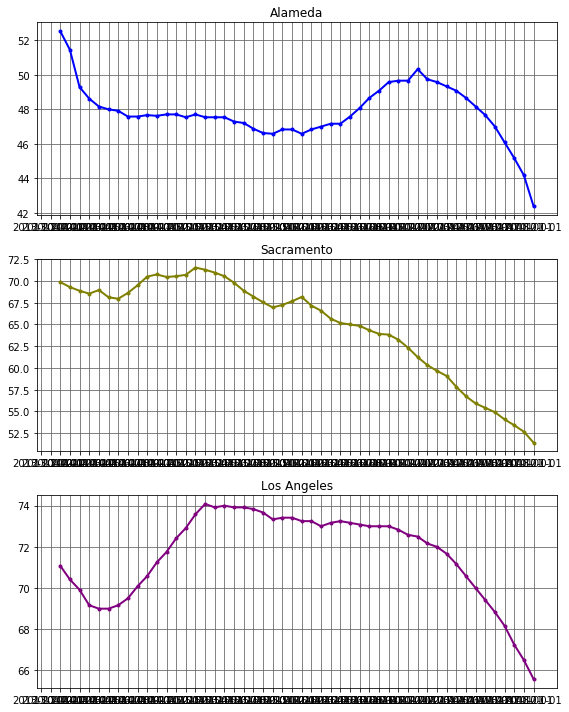

In [28]:
# smooth out the cycles. 
smoothing_factor = 12
alm_rolling_df = alameda_df.Days_On_Zillow.rolling(smoothing_factor).mean()  
sac_rolling_df = sacramento_df.Days_On_Zillow.rolling(smoothing_factor).mean()  
la_rolling_df = la_df.Days_On_Zillow.rolling(smoothing_factor).mean()  
 
# plot all - alameda, sac, la
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))     
    
ax1.plot(alameda_df.Date, alm_rolling_df, marker='.', color='blue', linewidth=2,)
ax1.title.set_text('Alameda')


ax2.plot(sacramento_df.Date, sac_rolling_df, marker='.', color='olive', linewidth=2,)
ax2.title.set_text('Sacramento')

ax3.plot(la_df.Date, la_rolling_df, marker='.', color='purple', linewidth=2,)
ax3.title.set_text('Los Angeles')


ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax2.grid(b=True, which='major', color='#666666', linestyle='-')
ax3.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()    

#### 4.3. Alameda - correlation between Sale Price and Rolling # of days on Zillow

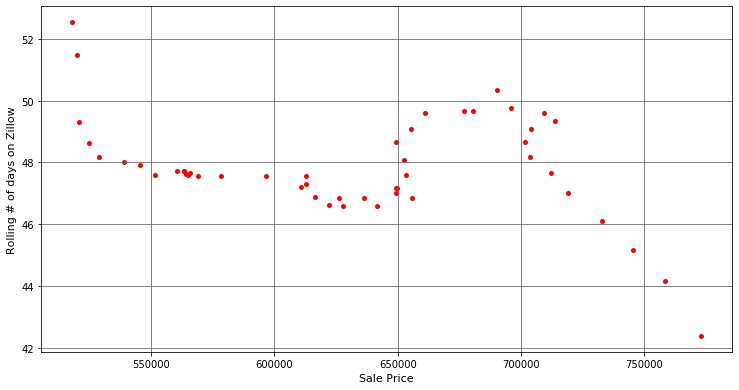

In [29]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8]) 
axes.scatter( alameda_df.SalePrice, alm_rolling_df, marker='.', color='red', linewidth=2,)

plt.xlabel('Sale Price', fontsize=11)
plt.ylabel('Rolling # of days on Zillow', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

#### 4.4. Alameda County - coorelation ( linear regression fit ) between percentage change between Sales price and percentage change of rolling # of days on Zillow

In [30]:
alm_rolling_days_change_perc=alm_rolling_df.pct_change()
alm_rolling_days_change_perc[0] = alm_rolling_days_change_perc.mean() 

sac_rolling_days_change_perc=sac_rolling_df.pct_change()
sac_rolling_days_change_perc[0] = sac_rolling_days_change_perc.mean() 

la_rolling_days_change_perc=la_rolling_df.pct_change()
la_rolling_days_change_perc[0] = la_rolling_days_change_perc.mean() 

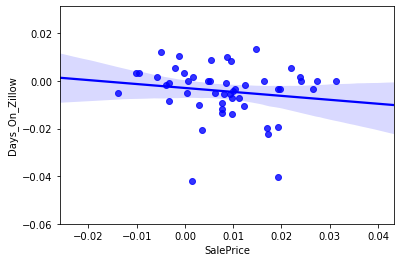

In [31]:
# Alameda

sns.regplot(y=alm_rolling_days_change_perc, x=alm_saleprice_change_perc, fit_reg = True, color='blue')

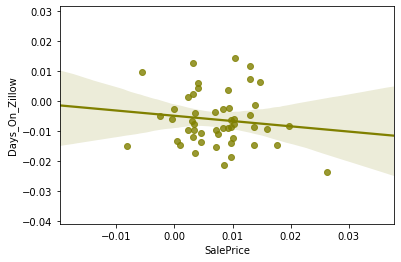

In [32]:
# Sacramento

sns.regplot(y=sac_rolling_days_change_perc, x=sac_saleprice_change_perc, fit_reg = True, color='olive')

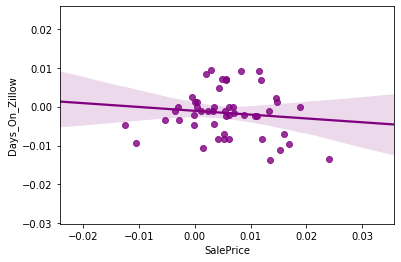

In [33]:
# LA

sns.regplot(y=la_rolling_days_change_perc, x=la_saleprice_change_perc, fit_reg = True, color='purple')

##### 4.4.1. Alameda County - compare sales price change percentage vs percentage change of rolling # of days on Zillow¶

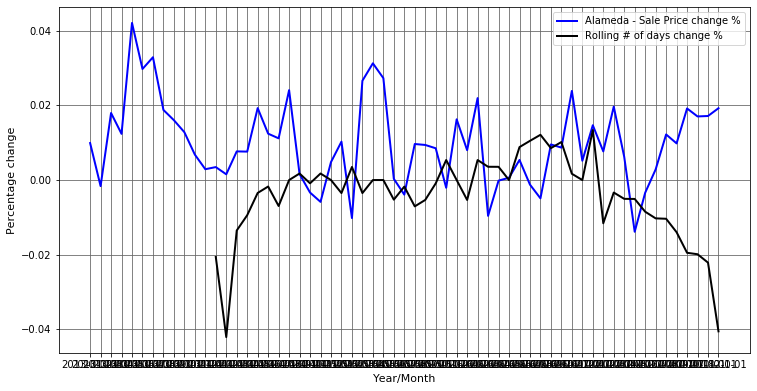

In [34]:
fig = plt.figure(figsize=(12,6))
axes= fig.add_axes([0.1,0.1,0.8,0.8]) 

axes.plot( alameda_df.Date, alm_saleprice_change_perc,  marker='', color='blue', linewidth=2)
axes.plot( alameda_df.Date, alm_rolling_days_change_perc, marker='', color='black', linewidth=2) 
axes.legend(['Alameda - Sale Price change %', 'Rolling # of days change %', ])

plt.xlabel('Year/Month', fontsize=11)
plt.ylabel('Percentage change', fontsize=11)
 
# Note for myself: tick spacing: https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/3/ch03lvl1sec48/controlling-tick-spacing    
#axes.xaxis.set_major_locator(ticker.MultipleLocator(6))
#axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.show()

### 5. Monthly number of Listings on Zillow

#### 5.1. Trend

As prices climb, number of listings go down in Alameda and LA counties but Sacramento seems to increase in listing, possibly because the prices are still affordable and existing home owners see this as chance to sell. 

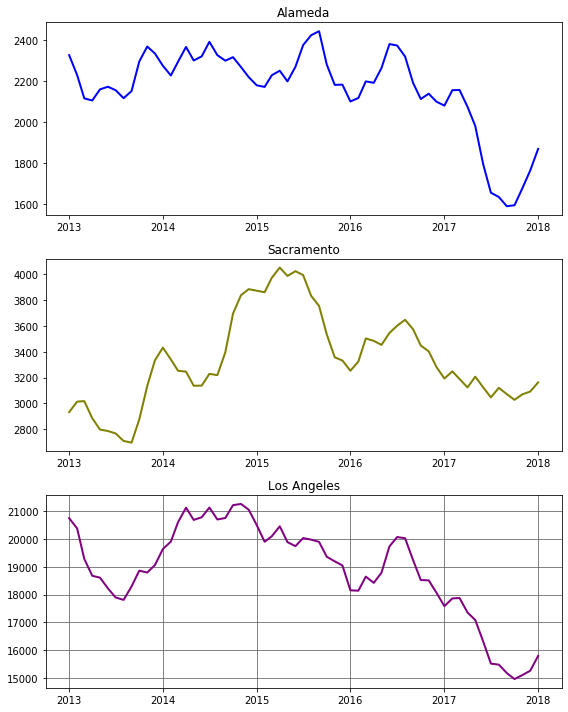

In [82]:
# plot all - alameda, sac, la
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))  

ax1.plot( 'Date', 'Monthly_List_Zillow',  data=alameda_df,  marker='', color='blue', linewidth=2,)
ax1.title.set_text('Alameda')


ax2.plot( 'Date', 'Monthly_List_Zillow', data=sacramento_df,   marker='', color='olive', linewidth=2,)
ax2.title.set_text('Sacramento')

ax3.plot( 'Date', 'Monthly_List_Zillow', data=la_df,  marker='', color='purple', linewidth=2,)
ax3.title.set_text('Los Angeles')


plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()

##### 5.1.1. Smooth out the cycles

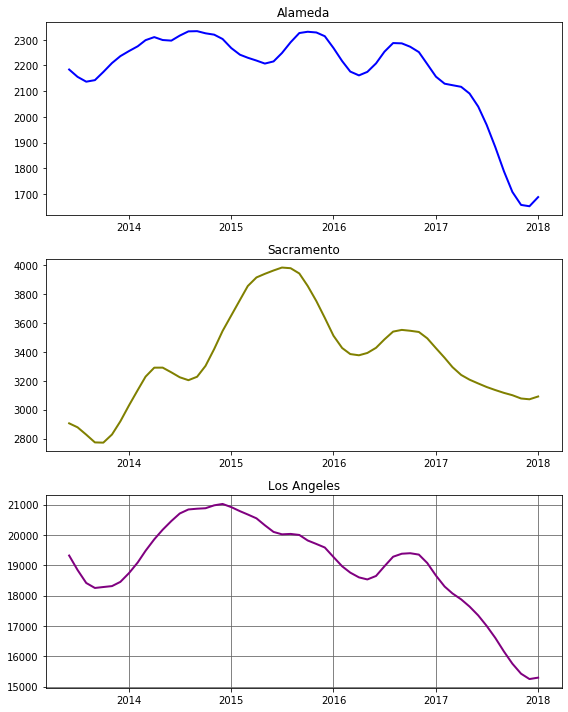

In [84]:
# smooth out the cycles. 
listing_smoothing_factor =6
alm_rolling_list_df = alameda_df.Monthly_List_Zillow.rolling(listing_smoothing_factor).mean()  
sac_rolling_list_df = sacramento_df.Monthly_List_Zillow.rolling(listing_smoothing_factor).mean()  
la_rolling_list_df = la_df.Monthly_List_Zillow.rolling(listing_smoothing_factor).mean()  


# plot all - alameda, sac, la
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))  

ax1.plot( alameda_df.Date, alm_rolling_list_df, marker='', color='blue', linewidth=2,)
ax1.title.set_text('Alameda')


ax2.plot( sacramento_df.Date, sac_rolling_list_df, marker='', color='olive', linewidth=2,)
ax2.title.set_text('Sacramento')

ax3.plot( la_df.Date, la_rolling_list_df, marker='', color='purple', linewidth=2,)
ax3.title.set_text('Los Angeles')


plt.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()

#### 5.2. Correlation between sales price and monthly listing (rolling 6 month average)

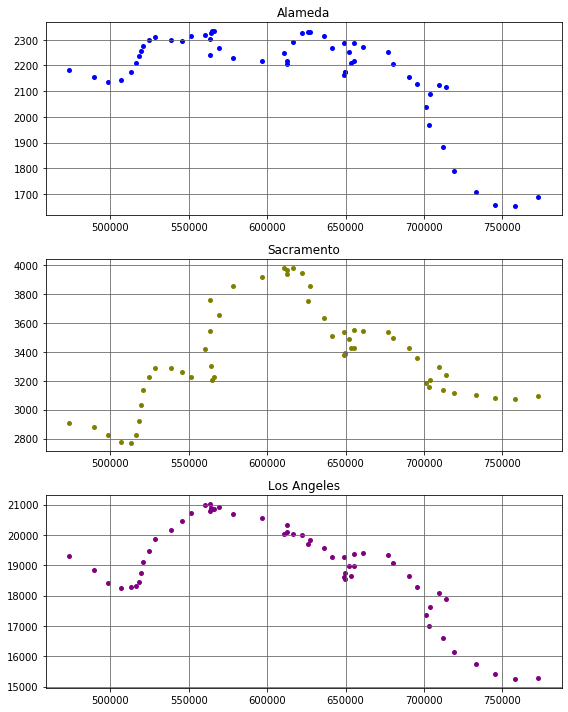

In [37]:
# plot all - alameda, sac, la
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,10))  

#ax1.scatter(alm_saleprice_change_perc, alm_list_change_perc, marker='.', color='red', linewidth=2)
ax1.scatter(alameda_df.SalePrice, alm_rolling_list_df, marker='.', color='blue', linewidth=2)
ax1.title.set_text('Alameda')


ax2.scatter(alameda_df.SalePrice, sac_rolling_list_df, marker='.', color='olive', linewidth=2)
ax2.title.set_text('Sacramento')

ax3.scatter(alameda_df.SalePrice, la_rolling_list_df, marker='.', color='purple', linewidth=2)
ax3.title.set_text('Los Angeles')


ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax2.grid(b=True, which='major', color='#666666', linestyle='-')
ax3.grid(b=True, which='major', color='#666666', linestyle='-')

plt.tight_layout()

#### 5.3. Correlation between Sales price percentage change and month listing percentage change

In [38]:
# correlation between Sales price and month listing. 

alm_list_change_perc = alameda_df.Monthly_List_Zillow.pct_change()
alm_list_change_perc[0] = alm_list_change_perc.mean() 

sac_list_change_perc = sacramento_df.Monthly_List_Zillow.pct_change()
sac_list_change_perc[0] = sac_list_change_perc.mean() 

la_list_change_perc = la_df.Monthly_List_Zillow.pct_change()
la_list_change_perc[0] = la_list_change_perc.mean() 


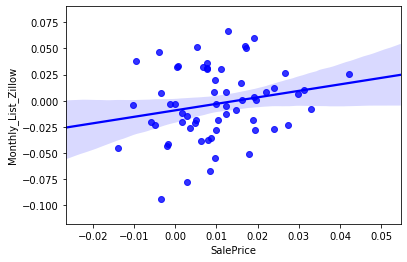

In [39]:
# Alameda 
sns.regplot(y=alm_list_change_perc, x=alm_saleprice_change_perc,  fit_reg = True, color='blue')

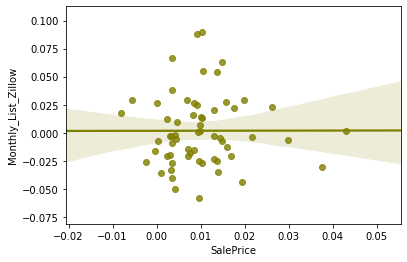

In [40]:
# Sacramento 
sns.regplot(y=sac_list_change_perc, x=sac_saleprice_change_perc,  fit_reg = True, color='olive')

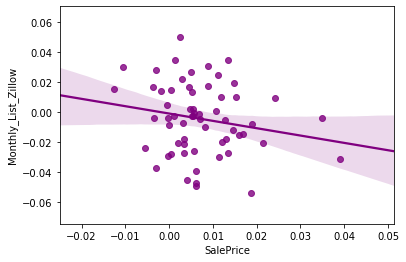

In [41]:
# LA 
sns.regplot(y=la_list_change_perc, x=la_saleprice_change_perc,  fit_reg = True, color='purple')

### 6. Afford_idx - Quarterly by County
Housing Affordability Index = ( Median Family Income / Qualifying Income ) * 100

#### 6.1. Prepare Quarterly average Sales Price
#### 6.2. Graph trend

In [42]:
# set DateTime index
alameda_df['Date'] = pd.to_datetime(alameda_df['Date']) 
alameda_by_date = alameda_df.set_index('Date')

sacramento_df['Date'] = pd.to_datetime(sacramento_df['Date']) 
sacramento_by_date = sacramento_df.set_index('Date')

la_df['Date'] = pd.to_datetime(la_df['Date']) 
la_by_date = la_df.set_index('Date')


C:\Users\yulmee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\yulmee\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\yulmee\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [43]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Afford_idx', 'SalePrice']

# Get average sales price for each quarter - Alameda
alameda_quarterly = alameda_by_date[data_columns].resample('Q').mean()

# Get average sales price for each quarter - Sacramento
sacramento_quarterly = sacramento_by_date[data_columns].resample('Q').mean()

# Get average sales price for each quarter - LA
la_quarterly = la_by_date[data_columns].resample('Q').mean()
la_quarterly.head()


,Afford_idx,SalePrice
Date,,
2013-03-31,0.420000,369200.000000
2013-06-30,0.370000,400733.333333
2013-09-30,0.270000,420533.333333
2013-12-31,0.300000,426233.333333
2014-03-31,0.309346,422366.666667


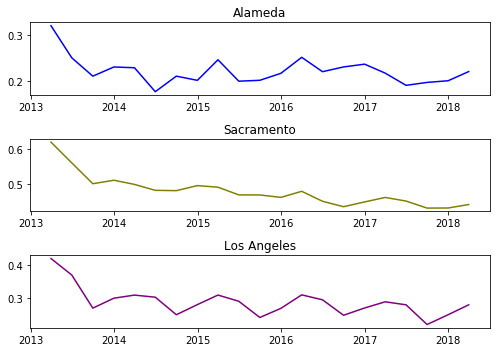

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,5))  

ax1.plot( alameda_quarterly.index, alameda_quarterly.Afford_idx, marker='', color='blue')
ax1.title.set_text('Alameda')

ax2.plot( sacramento_quarterly.index, sacramento_quarterly.Afford_idx, marker='', color='olive')
ax2.title.set_text('Sacramento')

ax3.plot( la_quarterly.index, la_quarterly.Afford_idx, marker='', color='purple')
ax3.title.set_text('Los Angeles')

plt.tight_layout()

#### 6.3. Sales Price trend against quarterly affordability index

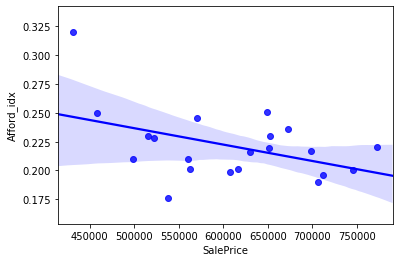

In [45]:
# Alameda
sns.regplot(y=alameda_quarterly.Afford_idx, x=alameda_quarterly.SalePrice,  fit_reg = True, color='blue')

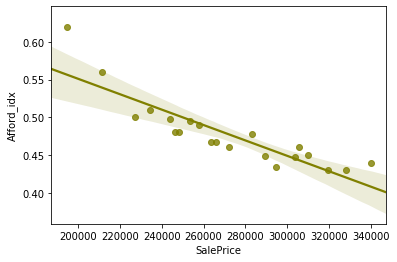

In [46]:
# Sacramento
sns.regplot(y=sacramento_quarterly.Afford_idx, x=sacramento_quarterly.SalePrice,  fit_reg = True, color='olive')

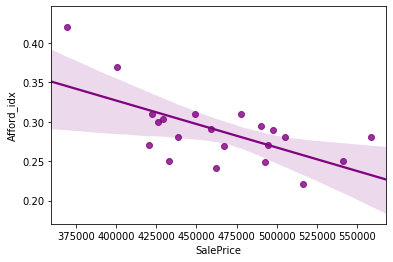

In [80]:
# LA
sns.regplot(y=la_quarterly.Afford_idx, x=la_quarterly.SalePrice,  fit_reg = True, color='purple')

### Prepare Annual data

In [48]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Population','Property_Crimes','Violent_Crimes', 'SalePrice']

# Get average for each year - Alameda
# Resample to weekly frequency, aggregating with mean
alameda_yearly = alameda_by_date[data_columns].resample('Y').mean()

# Get average sales price for each year - Sacramento
sacramento_yearly = sacramento_by_date[data_columns].resample('Y').mean()

# Get average sales price for each year - LA

la_yearly = la_by_date[data_columns].resample('Y').mean()
la_yearly.head(20)

,Population,Property_Crimes,Violent_Crimes,SalePrice
Date,,,,
2013-12-31,9968270.5,1018333.0,151634.0,404175.000000
2014-12-31,10023256.5,946682.0,151425.0,430725.000000
2015-12-31,10072722.5,1023828.0,166588.0,459541.666667
2016-12-31,10108788.5,1001380.0,174701.0,488983.333333
2017-12-31,10119649.5,986769.0,178553.0,515291.666667
2018-12-31,10118759.0,940998.0,176866.0,558700.000000


### 7. Population - annual by county

#### 7.1. Trend

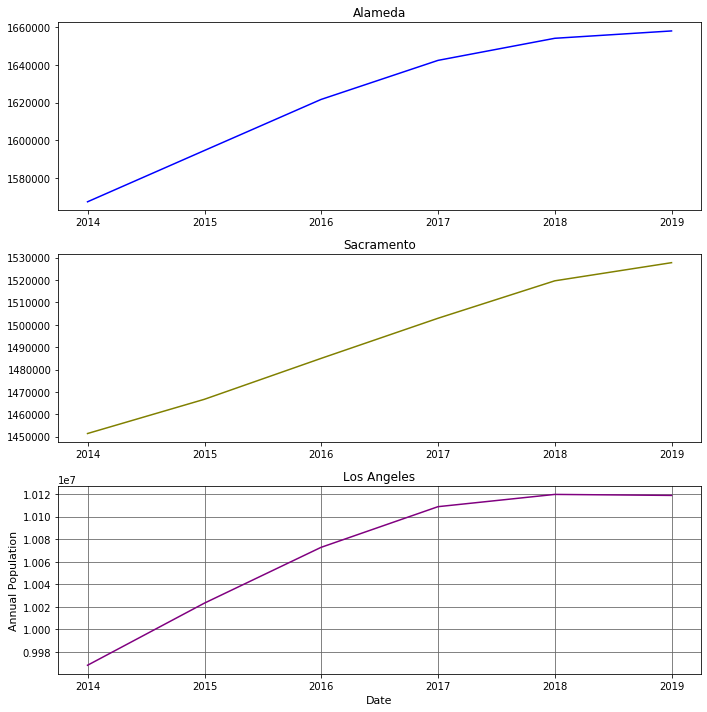

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10))  


ax1.plot( alameda_yearly.index, alameda_yearly.Population, marker='', color='blue')
ax1.title.set_text('Alameda')

ax2.plot( sacramento_yearly.index, sacramento_yearly.Population, marker='', color='olive')
ax2.title.set_text('Sacramento')

ax3.plot( la_yearly.index, la_yearly.Population, marker='', color='purple')
ax3.title.set_text('Los Angeles')

plt.xlabel('Date', fontsize=11)
plt.ylabel('Annual Population', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
 

plt.tight_layout()

#### 7.2. Correlation between sales price and population 

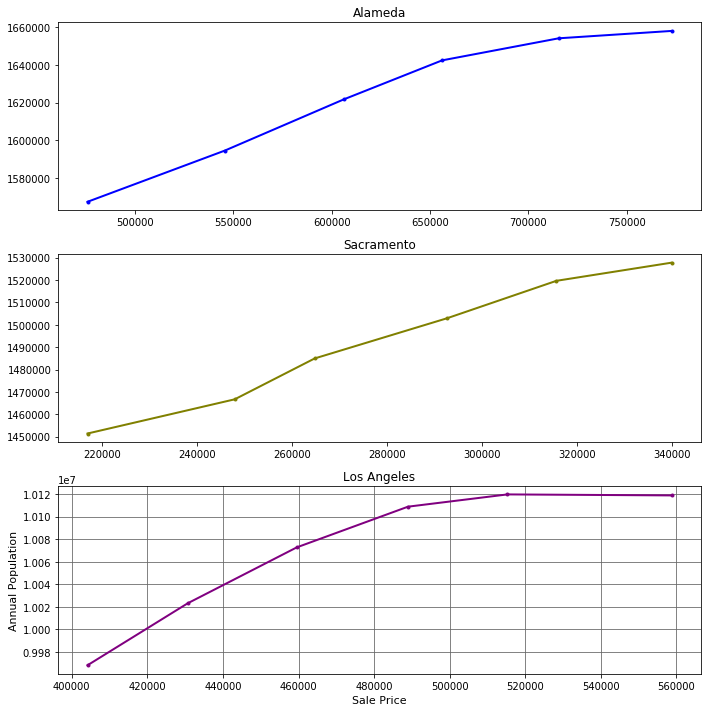

In [50]:
# 
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10))  


ax1.plot( alameda_yearly.SalePrice, alameda_yearly.Population, marker='.', color='blue', linewidth=2)
ax1.title.set_text('Alameda')

ax2.plot( sacramento_yearly.SalePrice, sacramento_yearly.Population, marker='.', color='olive', linewidth=2)
ax2.title.set_text('Sacramento')

ax3.plot( la_yearly.SalePrice, la_yearly.Population, marker='.', color='purple', linewidth=2)
ax3.title.set_text('Los Angeles')

plt.xlabel('Sale Price', fontsize=11)
plt.ylabel('Annual Population', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
 
plt.tight_layout()


### 8. Property_Crimes - Annual - State level

#### 8.1. Trend


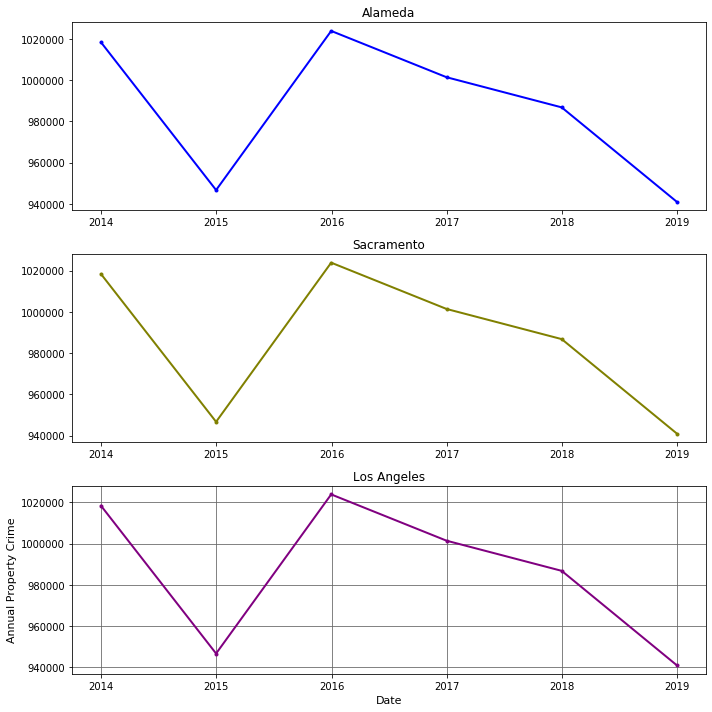

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10))  


ax1.plot( alameda_yearly.index, alameda_yearly.Property_Crimes, marker='.', color='blue', linewidth=2)
ax1.title.set_text('Alameda')

ax2.plot( sacramento_yearly.index, sacramento_yearly.Property_Crimes, marker='.', color='olive', linewidth=2)
ax2.title.set_text('Sacramento')

ax3.plot( la_yearly.index, la_yearly.Property_Crimes, marker='.', color='purple', linewidth=2)
ax3.title.set_text('Los Angeles')

plt.xlabel('Date', fontsize=11)
plt.ylabel('Annual Property Crime', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
 
plt.tight_layout()


#### 8.2. Correlation between sales price and property crimes

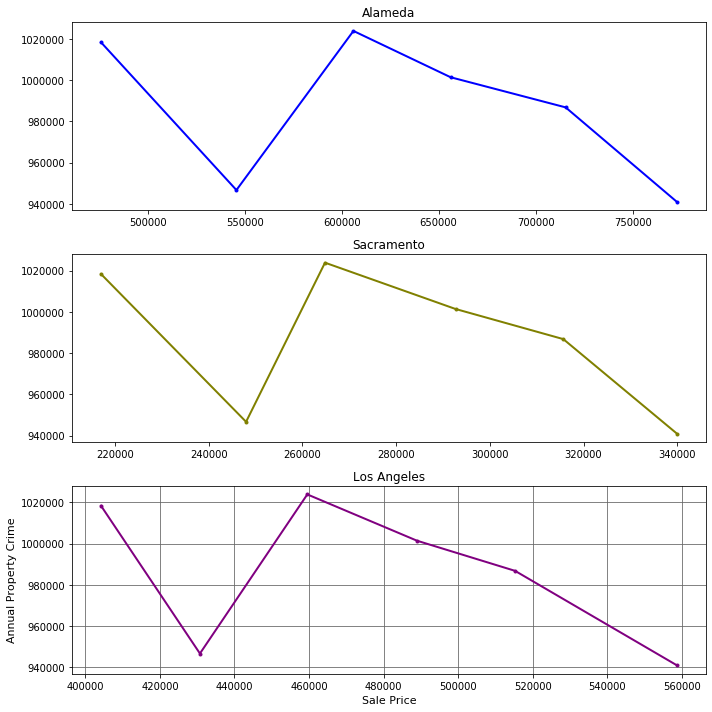

In [52]:
# 
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10))  


ax1.plot( alameda_yearly.SalePrice, alameda_yearly.Property_Crimes, marker='.', color='blue', linewidth=2)
ax1.title.set_text('Alameda')

ax2.plot( sacramento_yearly.SalePrice, sacramento_yearly.Property_Crimes, marker='.', color='olive', linewidth=2)
ax2.title.set_text('Sacramento')

ax3.plot( la_yearly.SalePrice, la_yearly.Property_Crimes, marker='.', color='purple', linewidth=2)
ax3.title.set_text('Los Angeles')

plt.xlabel('Sale Price', fontsize=11)
plt.ylabel('Annual Property Crime', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
 
plt.tight_layout()

### 9. Violent_Crimes  - Annual - State level

#### 9.1. Trend

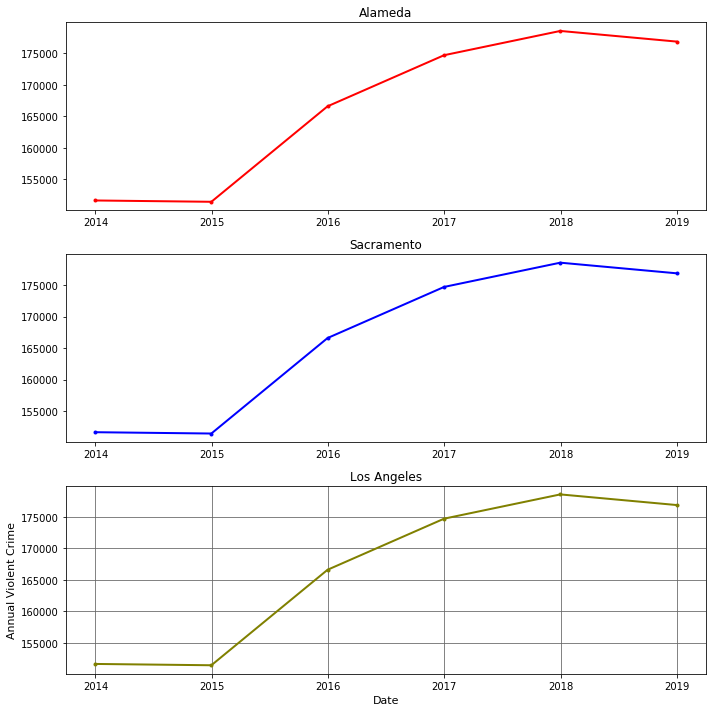

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10))  

ax1.plot( alameda_yearly.index, alameda_yearly.Violent_Crimes, marker='.', color='red', linewidth=2)
ax1.title.set_text('Alameda')

ax2.plot( sacramento_yearly.index, sacramento_yearly.Violent_Crimes, marker='.', color='blue', linewidth=2)
ax2.title.set_text('Sacramento')

ax3.plot( la_yearly.index, la_yearly.Violent_Crimes, marker='.', color='olive', linewidth=2)
ax3.title.set_text('Los Angeles')

plt.xlabel('Date', fontsize=11)
plt.ylabel('Annual Violent Crime', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
 
plt.tight_layout()

#### 9.2. Correlation between sales price and violent crimes.

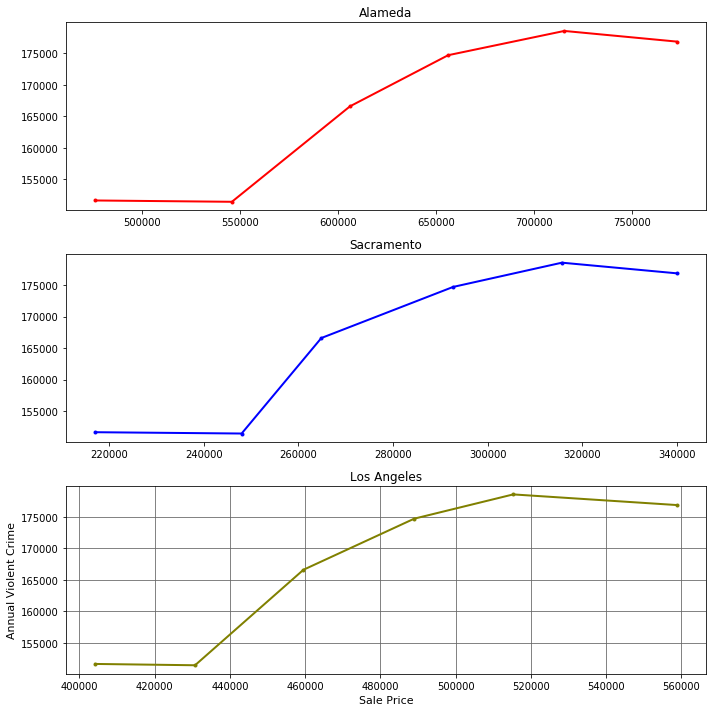

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10))  

ax1.plot( alameda_yearly.SalePrice, alameda_yearly.Violent_Crimes, marker='.', color='red', linewidth=2)
ax1.title.set_text('Alameda')

ax2.plot( sacramento_yearly.SalePrice, sacramento_yearly.Violent_Crimes, marker='.', color='blue', linewidth=2)
ax2.title.set_text('Sacramento')

ax3.plot( la_yearly.SalePrice, la_yearly.Violent_Crimes, marker='.', color='olive', linewidth=2)
ax3.title.set_text('Los Angeles')

plt.xlabel('Sale Price', fontsize=11)
plt.ylabel('Annual Violent Crime', fontsize=11)

plt.grid(b=True, which='major', color='#666666', linestyle='-')
 
plt.tight_layout()